# CAFA 5 protein function Prediction

This notebook uses PyTorch to train a NN model on CAFA 5 protein function Prediction dataset. Big part of this notebook was inspired by https://www.kaggle.com/code/gusthema/cafa-5-protein-function-with-tensorflow, especially the preprocessing part of this notebook.

The objective of the model is to predict the function(aka **GO term ID**) of a set of proteins based on their amino acid sequences and other data.


**Note** : This notebook runs without any GPU. This is because enabling GPUs leaves less RAM memory on the VM and the submission step needs a lot of memory. One point where this would impact is when training the model.

## About the Data

### Protein Sequence

Each protein is composed of dozens or hundreds of amino acids that are linked sequentially. Each amino acid in the sequence may be represented by a one-letter or three-letter code. Thus the sequence of a protein is often notated as a string of letters. 

<img src="https://cityu-bioinformatics.netlify.app/img/tools/protein/pro_seq.png" alt ="Sequence.png" style='width: 800px;' >

Image source - [https://cityu-bioinformatics.netlify.app/](https://cityu-bioinformatics.netlify.app/too2/new_proteo/pro_seq/)

The `train_sequences.fasta` made available for this competitions, contains the sequences for proteins with annotations (labelled proteins).

# Gene Ontology

We can define the functional properties of a proteins using Gene Ontology(GO). Gene Ontology (GO) describes our understanding of the biological domain with respect to three aspects:
1. Molecular Function (MF)
2. Biological Process (BP)
3. Cellular Component (CC)

Read more about Gene Ontology [here](http://geneontology.org/docs/ontology-documentation).

File `train_terms.tsv` contains the list of annotated terms (ground truth) for the proteins in `train_sequences.fasta`. In `train_terms.tsv` the first column indicates the protein's UniProt accession ID (unique protein id), the second is the `GO Term ID`, and the third indicates in which ontology the term appears. 

# Labels of the dataset

The objective of our model is to predict the terms (functions) of a protein sequence. One protein sequence can have many functions and can thus be classified into any number of terms. Each term is uniquely identified by a `GO Term ID`. Thus our model has to predict all the `GO Term ID`s for a protein sequence. This means that the task at hand is a multi-label classification problem. 

# Protein embeddings for train and test data

To train a machine learning model we cannot use the alphabetical protein sequences in`train_sequences.fasta` directly.<br>
In this notebook, we will use embeddings of the protein sequences to train the model.

There are a couple of protein embeddings availible. We have tried 3 different precalculated protein embeddings:
- ProtT5: created by [Sergei Fironov](https://www.kaggle.com/sergeifironov) found [here](https://www.kaggle.com/datasets/sergeifironov/t5embeds).
- ProtBERT: created by [Henri Upton](https://www.kaggle.com/henriupton) using the Rost Lab's ProtBERT protein language model. The precalculated protein embeddings can be found [here](https://www.kaggle.com/datasets/henriupton/protbert-embeddings-for-cafa5)
- EMS-2: created by [Viktor Fairuschin](https://www.kaggle.com/viktorfairuschin) found [here](https://www.kaggle.com/datasets/viktorfairuschin/cafa-5-ems-2-embeddings-numpy)

T5 and ProtBERT use dimension size of 1024 and EMS2 dimesion of 1280.

# Import the Required Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Required for progressbar widget
import progressbar

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 6.5 MB/s eta 0:00:00


In [3]:
import itertools
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import BinaryAccuracy
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import gc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


# Load the Dataset

First we will load the file `train_terms.tsv` which contains the list of annotated terms (functions) for the proteins. We will extract the labels aka `GO term ID` and create a label dataframe for the protein embeddings.

In [4]:
train_terms = pd.read_csv("/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv",sep="\t")
print(train_terms.shape)

(5363863, 3)


`train_terms` dataframe is composed of 3 columns and 5363863 entries. We can see all 3 dimensions of our dataset by printing out the first 5 entries using the following code:

In [5]:
train_terms.head()

EntryID        term aspect
0  A0A009IHW8  GO:0008152    BPO
1  A0A009IHW8  GO:0034655    BPO
2  A0A009IHW8  GO:0072523    BPO
3  A0A009IHW8  GO:0044270    BPO
4  A0A009IHW8  GO:0006753    BPO

If we look at the first entry of `train_terms.tsv`, we can see that it contains protein id(`A0A009IHW8`), the GO term(`GO:0008152`) and its aspect(`BPO`). 

# Loading the protein embeddings


We will now load 3 different pre-calculated protein embeddings:
1. [ProtT5](https://www.kaggle.com/datasets/sergeifironov/t5embeds) created by [Sergei Fironov](https://www.kaggle.com/sergeifironov)
2. [ProtBERT](https://www.kaggle.com/datasets/henriupton/protbert-embeddings-for-cafa5) created by [Henry Upton](https://www.kaggle.com/henriupton) using the Rost Lab's ProtBERT protein language model.
3. [EMS-2](https://www.kaggle.com/datasets/viktorfairuschin/cafa-5-ems-2-embeddings-numpy) created by [Viktor Fairushin](https://www.kaggle.com/viktorfairuschin)

The protein embeddings to be used for training are recorded in `train_embeds.npy` and the corresponding protein ids are available in `train_ids.npy`.

In [6]:
# Directories for the different embedding vectors : 
embeddings = {
    "train": {
            
        "T5": {"ids_path": "/kaggle/input/t5embeds/train_ids.npy",
                "embeds_path": "/kaggle/input/t5embeds/train_embeds.npy"
               },

        "ProtBERT": {"ids_path": "/kaggle/input/protbert-embeddings-for-cafa5/train_ids.npy",
                      "embeds_path": "/kaggle/input/protbert-embeddings-for-cafa5/train_embeddings.npy"
                     },

        "EMS2": {"ids_path": "/kaggle/input/cafa-5-ems-2-embeddings-numpy/train_ids.npy",
                 "embeds_path": "/kaggle/input/cafa-5-ems-2-embeddings-numpy/train_embeddings.npy"
                }
    },
    "test": {
            
        "T5": {"ids_path": "/kaggle/input/t5embeds/test_ids.npy",
                "embeds_path": "/kaggle/input/t5embeds/test_embeds.npy"
               },

        "ProtBERT": {"ids_path": "/kaggle/input/protbert-embeddings-for-cafa5/test_ids.npy",
                      "embeds_path": "/kaggle/input/protbert-embeddings-for-cafa5/test_embeddings.npy"
                     },

        "EMS2": {"ids_path": "/kaggle/input/cafa-5-ems-2-embeddings-numpy/test_ids.npy",
                 "embeds_path": "/kaggle/input/cafa-5-ems-2-embeddings-numpy/test_embeddings.npy"
                }
    }
}

In [7]:
embed_type = "EMS2"
curr_embed_train = embeddings['train'][embed_type]

First, we will load the protein ids of the protein embeddings in the train dataset contained in `train_ids.npy` into a numpy array.

In [8]:
train_protein_ids = np.load(curr_embed_train["ids_path"])
print(train_protein_ids.shape)

(142246,)


Let us print out the first 5 `train_protein_ids` using the following code:

In [9]:
train_protein_ids[:5]

array(['Q9ZSA8', 'P25353', 'A0A2R8YCW8', 'G3V5N8', 'A0A140LFN4'],
      dtype='<U10')

Now, we will load`train_embeds.py` which contains the pre-calculated embeddings of the proteins in the train dataset. with protein_ids (`id`s we loaded previously from the **train_ids.npy**) into a numpy array. This array now contains the precalculated embeddings for the protein_ids( Ids we loaded above from **train_ids.npy**) needed for training.

After loading the files as numpy arrays, we will convert them into Pandas dataframe.

Each protein embedding has its vector of length (1024 for T5 and ProtBERT and 1280 for EMS-2). We create the resulting dataframe such that there are 1024/1280 columns to represent the values in each of the 1024/1280 places in the vector.

In [10]:
train_embeddings = np.load(curr_embed_train["embeds_path"])

# Now lets convert embeddings numpy array(train_embeddings) into pandas dataframe.
column_num = train_embeddings.shape[1]
train_df = pd.DataFrame(train_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(train_df.shape)

(142246, 1280)


The `train_df` dataframe which contains the embeddings is composed of 1024/1280 columns and 142246 entries. We can see all 1024/1280 dimensions (results will be truncated since column length is too long) of our dataset by printing out the first 5 entries using the following code:

In [11]:
train_df.head()

Column_1  Column_2  Column_3  Column_4  Column_5  Column_6  Column_7  \
0 -0.092291 -0.066284 -0.012262  0.044118 -0.096111 -0.028308 -0.074759   
1  0.011624 -0.030318 -0.005802  0.029026  0.028326 -0.034560  0.003770   
2  0.027373 -0.041047 -0.029205  0.028087 -0.012250 -0.066159  0.030800   
3  0.033766 -0.078889 -0.059741  0.045629 -0.060334 -0.015612  0.059876   
4  0.011948 -0.002108 -0.084922  0.068762  0.002155 -0.093367  0.114656   

   Column_8  Column_9  Column_10  ...  Column_1271  Column_1272  Column_1273  \
0  0.100977  0.024241   0.083448  ...     0.003669    -0.076738    -0.023574   
1 -0.081593 -0.050148  -0.007592  ...     0.082000     0.007247    -0.062506   
2  0.039873  0.000206   0.055686  ...     0.083869     0.008130    -0.122658   
3 -0.038531 -0.001667   0.075625  ...     0.029910    -0.010136    -0.007829   
4  0.040136  0.067143   0.073344  ...    -0.030091     0.021493    -0.246086   

   Column_1274  Column_1275  Column_1276  Column_1277  Column_1278  \
0     0.013527    -0.104102    -0.047541     0.043210    -0.160660   
1     0.095455    -0.063068    -0.010131     0.042478    -0.153411   
2    -0.020470     0.016220    -0.014810     0.069728    -0.051237   
3     0.052135     0.009843    -0.006972     0.037077    -0.103541   
4     0.030696    -0.050064     0.078881     0.008374    -0.050359   

   Column_1279  Column_1280  
0     0.015920     0.001738  
1     0.006632     0.001425  
2    -0.010532     0.022564  
3     0.010925     0.158402  
4    -0.055477     0.020290  

[5 rows x 1280 columns]

# Prepare the dataset

Reference: https://www.kaggle.com/code/alexandervc/baseline-multilabel-to-multitarget-binary<br>
First we will extract all the needed labels(`GO term ID`) from `train_terms.tsv` file. There are more than 40,000 labels. In rules of the competition we can only use 1500 labels maximum for training, so we will choose the most frequent 1500 `GO term ID`s as labels.

Let's plot the most frequent 100 `GO Term ID`s in `train_terms.tsv`.

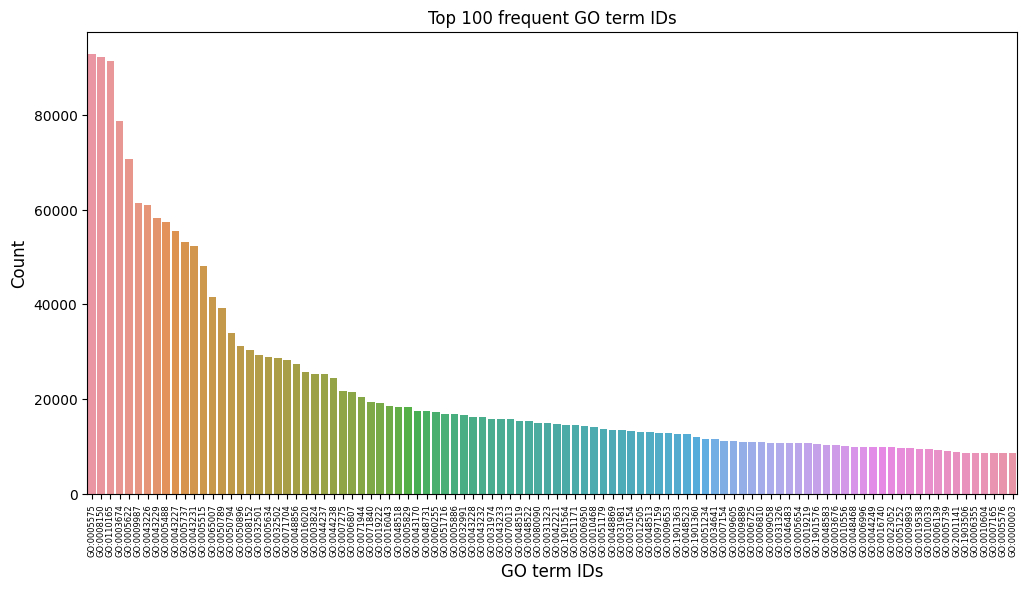

In [12]:
# Select first 1500 values for plotting
plot_df = train_terms['term'].value_counts().iloc[:100]

figure, axis = plt.subplots(1, 1, figsize=(12, 6))

bp = sns.barplot(ax=axis, x=np.array(plot_df.index), y=plot_df.values)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 6)
axis.set_title('Top 100 frequent GO term IDs')
bp.set_xlabel("GO term IDs", fontsize = 12)
bp.set_ylabel("Count", fontsize = 12)
plt.show()

In [13]:
print(train_terms['term'].value_counts().iloc[1500])

430


We will now save the first 1500 most frequent GO term Ids into a list.

In [14]:
# Set the limit for label
num_of_labels = 1500

# Take value counts in descending order and fetch first 1500 `GO term ID` as labels
labels = train_terms['term'].value_counts().index[:num_of_labels].tolist()

Next, we will create a new dataframe by filtering the train terms with the selected `GO Term ID`s.

In [15]:
# Fetch the train_terms data for the relevant labels only
train_terms_updated = train_terms.loc[train_terms['term'].isin(labels)]

Since this is a multi label classification problem, in the labels array we will denote the presence or absence of each Go Term Id for a protein id using a 1 or 0.<br>
Reference: https://www.kaggle.com/code/gusthema/cafa-5-protein-function-with-tensorflow/comments#2346982

In [16]:
train_terms_updated_copy = train_terms_updated.copy()
train_terms_updated_copy['has_label'] = 1
df_pivot = train_terms_updated_copy[train_terms_updated_copy.term.isin(labels)].pivot_table(index='EntryID', columns='term', values='has_label', fill_value=0).astype(int)
labels_df = df_pivot.loc[train_protein_ids, labels]

The final labels dataframe (`label_df`) is composed of 1500 columns and 142246 entries. We can see all 1500 dimensions(results will be truncated since the number of columns is big) of our dataset by printing out the first 5 entries using the following code:

In [17]:
labels_df.head()

term        GO:0005575  GO:0008150  GO:0110165  GO:0003674  GO:0005622  \
EntryID                                                                  
Q9ZSA8               0           1           0           0           0   
P25353               0           1           0           1           0   
A0A2R8YCW8           1           0           1           0           1   
G3V5N8               1           0           1           0           1   
A0A140LFN4           0           1           0           0           0   

term        GO:0009987  GO:0043226  GO:0043229  GO:0005488  GO:0043227  ...  \
EntryID                                                                 ...   
Q9ZSA8               1           0           0           0           0  ...   
P25353               1           0           0           0           0  ...   
A0A2R8YCW8           0           0           0           0           0  ...   
G3V5N8               0           1           1           0           1  ...   
A0A140LFN4           1           0           0           0           0  ...   

term        GO:0034250  GO:0140053  GO:0031345  GO:0098802  GO:0045861  \
EntryID                                                                  
Q9ZSA8               0           0           0           0           0   
P25353               0           0           0           0           0   
A0A2R8YCW8           0           0           0           0           0   
G3V5N8               0           0           0           0           0   
A0A140LFN4           0           0           0           0           0   

term        GO:0051783  GO:0031674  GO:0001818  GO:0006874  GO:0016887  
EntryID                                                                 
Q9ZSA8               0           0           0           0           0  
P25353               0           0           0           0           0  
A0A2R8YCW8           0           0           0           0           0  
G3V5N8               0           0           0           0           0  
A0A140LFN4           0           0           0           0           0  

[5 rows x 1500 columns]

# Training
We will try two model architectures. First is MLP and the second is CNN.

We will then try to optimize hyperparameters of these NN architectures and then train the model with the best parameters.

As our loss function we will be using Binary Cross Entropy and we will be also calculating Binary Accuracy.

Firstly we will split our training data into train and validation. Since we have a lot of data I used only 10% for the validation dataset.

In [18]:
from sklearn.model_selection import train_test_split

train_train_df, val_train_df, train_labels_df, val_labels_df = train_test_split(train_df, labels_df, test_size=0.1)

In [19]:
# Convert dfs to PyTorch tensors
train_data = torch.tensor(train_train_df.values, dtype=torch.float32)
train_labels = torch.tensor(train_labels_df.values, dtype=torch.float32)
val_data = torch.tensor(val_train_df.values, dtype=torch.float32)
val_labels = torch.tensor(val_labels_df.values, dtype=torch.float32)

# MLP Model
First model we use is MLP

We are optimizing multiple hyperparamets:
- number of units per layer (same for all layers)
- number of layers
- dropout rate (same for all layers)
- activation funcion (same for all layers)
- batch size
- learning rate

We are also using batch normaliztion function to normalize out input data (by placing batch normaliztion on the input layer)<br>
Also batch normalization is used on all of the other NN layers

In [20]:
 class MLPModel(nn.Module):
        def __init__(self, input_size, num_units, num_layers, num_labels, dropout_rate, activation):
            super(MLPModel, self).__init__()
            self.layers = nn.ModuleList([nn.Linear(input_size, num_units)])
            self.norms = nn.ModuleList([nn.BatchNorm1d(num_units)])
            for _ in range(num_layers - 1):
                self.layers.append(nn.Linear(num_units, num_units))
                self.norms.append(nn.BatchNorm1d(num_units))
            self.output_layer = nn.Linear(num_units, num_labels)
            self.batch_norm_input = nn.BatchNorm1d(input_size)
            self.dropout = nn.Dropout(p=dropout_rate)
            self.sigmoid = nn.Sigmoid()
            if activation == "gelu":
                self.activation = nn.GELU()
            elif activation == "lrelu":
                self.activation = nn.LeakyReLU()
            elif activation == "tanh":
                self.activation = nn.Tanh()
            else:
                self.activation = nn.ReLU()

        def forward(self, x):
            x = self.batch_norm_input(x)
            for layer, norm in zip(self.layers, self.norms):
                x = norm(layer(x))
                x = self.activation(x)
                x = self.dropout(x)
            x = self.output_layer(x)
            return self.sigmoid(x)

In [21]:
def train_model(model, train_loader, criterion, optimizer, baccuracy):
    model.train()
    total_loss = 0
    for batch_inputs, batch_labels in train_loader:
        batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        baccuracy.update(torch.flatten(outputs), torch.flatten(batch_labels))
        
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    
    return total_loss/len(train_loader), baccuracy.compute().item()


In [22]:
def test_model(model, test_data, test_labels, criterion, baccuracy):
    test_data = test_data.to(device)
    test_labels = test_labels.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(test_data)
        test_loss = criterion(outputs, test_labels).item()
        baccuracy.update(torch.flatten(outputs), torch.flatten(test_labels))
        
    return test_loss, baccuracy.compute().item()

### Hyperparam opt using Optuna
Since our computational resources are small and we want to optimize many hyperparameters we decided to use Optuna hyperparameter optimization. <br>
The biggest number of trails (hyperparameters combinations) we could fit into one session (12h) on Kaggle was 100.

In [23]:
import optuna

# Create DataLoader for training data (no need for validation data since they will be evaluated in single batch)
train_dataset = TensorDataset(train_data, train_labels)

# Initialize binary accuracy metric from torchmetrics
baccuracy = BinaryAccuracy()

num_epochs = 10

def objective(trial: optuna.Trial):
    num_layers = trial.suggest_int('num_layers', 2, 4)
    num_units = trial.suggest_categorical('num_units', [384, 512, 640, 900, 1024])
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.05, 0.1, 0.2, 0.3])
    ams_grad = trial.suggest_categorical('ams_grad', [True, False])
    optimizer_choice = trial.suggest_categorical('optimizer_choice', ['adam', 'nadam', 'adagrad'])
    batch_size = trial.suggest_categorical('batch_size', [64 ,128, 256, 512])
    activation = trial.suggest_categorical('activation', ["relu", "gelu", "lrelu", "tanh"])
    lr = trial.suggest_float('lr', 1e-3, 1e-1)
    
    best_val_accuracy = 0.0
    best_val_loss = 1000
    num_epochs = 10
    
    # Check duplication and skip if it's detected.           
    for t in study.get_trials(deepcopy=False):
        if t.state != optuna.trial.TrialState.COMPLETE:
            continue

        if t.params == trial.params:
            raise optuna.exceptions.TrialPruned('Duplicate parameter set')

    # Save currently trained hyperparameters to a file
    with open('MLP_output.txt', 'a') as file:
        file.write("Currently training: \n")
        
        for param_name, param_value in trial.params.items():
            file.write(f"{param_name}: {param_value} \n")
    
    # Create data loader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = MLPModel(train_train_df.shape[1], num_units, num_layers, num_of_labels, dropout_rate, activation)
    
    # Set criterion to Binary Cross-Entropy loss
    criterion = nn.BCELoss()
    
    # Select correct optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    if ams_grad:
        optimizer = optim.Adam(model.parameters(), lr=lr,amsgrad=True)
            
    if optimizer_choice == 'nadam':
        optimizer = optim.NAdam(model.parameters(), lr=lr)
            
    if optimizer_choice == 'adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=lr)
    
    # Reduce LR if loss will not be reducing
    scheduler = ReduceLROnPlateau(optimizer, patience=2, factor=0.1, verbose=False)
    
    for epoch in range(num_epochs):
        # Train model
        train_loss, train_bacc = train_model(model, train_loader, criterion, optimizer, baccuracy)
        baccuracy.reset()
        
        # Test model on validation dataset
        val_loss, val_bacc = test_model(model, val_data, val_labels, criterion, baccuracy)
        baccuracy.reset()
         
        scheduler.step(val_loss)
        
        # Update best val binary accuracy
        if val_bacc > best_val_accuracy:
            best_val_accuracy = val_bacc
            best_params_bacc = trial.params
        
        # Update best val loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params_loss = trial.params
    
    # Save models loss and binary accuracy to a file
    with open('MLP_output.txt', 'a') as file:
        file.write(f"Val Loss: {best_val_loss:.4f}, Train BAcc: {best_val_accuracy:.4f}\n\n")
    
    # Free up memory by deleting the model
    del model
    gc.collect()
    return best_val_loss

study = optuna.create_study(direction='minimize')

# optuna seemed to repeat certain trials so we try to avoid it by this trick
unique_trials = 1
while unique_trials > len(set(str(t.params) for t in study.trials)):
    try:
        study.optimize(objective, n_trials=1)
    except optuna.exceptions.TrialPruned as e:
        print(f"Trial pruned: {e}")

# Get the best hyperparameters and val_loss from the study
best_trial = study.best_trial
best_params = best_trial.params
best_val_loss = best_trial.value

# Print the best hyperparameters and val_loss
print("Best hyperparameters:")
for param_name, param_value in best_params.items():
    print(f"Best {param_name}: {param_value}")
print("Best val loss:", best_val_loss)

# Save best the best hyperparameters and val_loss
with open('MLP_output.txt', 'a') as file:
    for param_name, param_value in best_params.items():
        file.write(f"Best {param_name}: {param_value} \n")
    file.write(f"Best val loss: {best_val_loss:.4f} \n")


[I 2023-09-26 08:43:31,371] A new study created in memory with name: no-name-edf662c4-624b-4a46-b350-9c1651e4371a
[I 2023-09-26 09:16:05,509] Trial 0 finished with value: 0.06553120166063309 and parameters: {'num_layers': 4, 'num_units': 1024, 'dropout_rate': 0.3, 'ams_grad': False, 'optimizer_choice': 'nadam', 'batch_size': 64, 'activation': 'relu', 'lr': 0.07052369917989577}. Best is trial 0 with value: 0.06553120166063309.


Best hyperparameters:
Best num_layers: 4
Best num_units: 1024
Best dropout_rate: 0.3
Best ams_grad: False
Best optimizer_choice: nadam
Best batch_size: 64
Best activation: relu
Best lr: 0.07052369917989577
Best val loss: 0.06553120166063309


In [24]:
optuna.visualization.plot_slice(study)

### Hyperparam opt using Grid Search
We also tried using Grid Search since it does a faster job then Optuna but that doesnt allow us to do test as many hyperparameter values.

In [25]:
from itertools import product

# Define hyperparameter choices
num_layers_choices = [2, 3, 4]
num_units_choices = [768, 900, 1028]
dropout_rate = 0.2
optimizer_choices = ['nadam', 'adam']
batch_size = 256
lrs = [0.01, 0.001]
activation = "relu"

best_val_accuracy = 0.0
best_val_loss = 1000
best_params_loss = {}
best_params_bacc = {}

# Create DataLoader for training data
train_dataset = TensorDataset(train_data, train_labels)

# Initialize binary accuracy metric from torchmetrics
baccuracy = BinaryAccuracy()

num_epochs = 10

# Create all hyperparameter combinations
hyperparameter_combinations = product(num_layers_choices, num_units_choices, optimizer_choices, lrs)

# Perform grid hyperparameter search (iterate over every combination)
for num_layers, num_units, optimizer_choice, lr in hyperparameter_combinations:
    # Save models hyperparameters to a file
    with open('MLP_output.txt', 'a') as file:
        file.write("Currently training: \n")
        file.write(f"Number of layers: {num_layers}\n")
        file.write(f"Number of units in each layer: {num_units}\n")
        file.write(f"Dropout rate: {dropout_rate} \n")
        file.write(f"Optimizer: {optimizer_choice} \n")
        file.write(f"Batch size: {batch_size} \n")
        file.write(f"Learning rate: {lr} \n")
        
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = MLPModel(train_train_df.shape[1], num_units, num_layers, num_of_labels, dropout_rate, activation)
    
    # Set criterion to Binary Cross-Entropy loss
    criterion = nn.BCELoss()
    
    # Select correct optimizer
    optimizer = optim.NAdam(model.parameters(), lr=lr)
    if optimizer_choice == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, amsgrad=True)
    
    scheduler = ReduceLROnPlateau(optimizer, patience=2, factor=0.1, verbose=True)
    
    for epoch in range(num_epochs):
        # Train model
        train_loss, train_bacc = train_model(model, train_loader, criterion, optimizer, baccuracy)
        baccuracy.reset()
        
        # Test model on validation dataset
        val_loss, val_bacc = test_model(model, val_data, val_labels, criterion, baccuracy)
        baccuracy.reset()
         
        scheduler.step(val_loss)
        
        # Update best val binary accuracy
        if val_bacc > best_val_accuracy:
            best_val_accuracy = val_bacc
            best_params_bacc = {
                'num_layers': num_layers,
                'num_units': num_units,
                'dropout_rate': dropout_rate,
                'optimizer': optimizer_choice,
                'batch_size': batch_size,
                'lr': lr
            }
        
        # Update best val loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params_loss = {
                'num_layers': num_layers,
                'num_units': num_units,
                'dropout_rate': dropout_rate,
                'optimizer': optimizer_choice,
                'batch_size': batch_size,
                'lr': lr
            }
            
        # Save models loss and binary accuracy to a file
        with open('MLP_output.txt', 'a') as file:
            file.write(f"Epoch [{epoch+1}/{num_epochs}]:\nTrain Loss: {train_loss:.4f}, Train BAcc: {train_bacc:.4f}\n")
            file.write(f"Val Loss: {val_loss:.4f}, Train BAcc: {val_bacc:.4f}\n\n")
            
        
    # Print the current best results
    print("Current best binary accuracy: ", best_val_accuracy)
    print("Current best val loss: ", best_val_loss)
    
    # Free up memory by deleting the model
    del model
    gc.collect()
    
    # for show purpose
    break

# Print the best hyperparameter values
print("Best number of layers:", best_params_bacc['num_layers'])
print("Best number of units in each layer:", best_params_bacc['num_units'])
print("Best dropout rate:", best_params_bacc['dropout_rate'])
print("Best optimizer:", best_params_bacc['optimizer'])
print("Best batch size:", best_params_bacc['batch_size'])
print("Best binary accuracy:", best_val_accuracy)

# Print the best hyperparameter values
print("Best number of layers:", best_params_loss['num_layers'])
print("Best number of units in each layer:", best_params_loss['num_units'])
print("Best dropout rate:", best_params_loss['dropout_rate'])
print("Best optimizer:", best_params_loss['optimizer'])
print("Best batch size:", best_params_loss['batch_size'])
print("Best binary accuracy:", best_val_loss)

Current best binary accuracy:  0.9816293120384216
Current best val loss:  0.05744970217347145
Best number of layers: 2
Best number of units in each layer: 768
Best dropout rate: 0.2
Best optimizer: nadam
Best batch size: 256
Best binary accuracy: 0.9816293120384216
Best number of layers: 2
Best number of units in each layer: 768
Best dropout rate: 0.2
Best optimizer: nadam
Best batch size: 256
Best binary accuracy: 0.05744970217347145


# 1D CNN
Another NN architecture we tried was 1D Convolutional Neural Network.
Unfortunatelly we didn't have much time left in the competition so we didn't manage to optimize the CNN much and since it seemed to us that it was providing worse results them MLP we decided to focus our recources on that.

Also optimazing CNN took way more time so we couldn't test as many hyperparameter values in one session.

We used a model with 2 Convolutional layers and one hidden linear layer.

Hyperparametrs we optimized:
 - number of output channels for first Convolutional layer
 - number of output channels for second Convolutional layer
 - number of units for hidden linear layer
 - dropout rate fort hidden linear layer
 - activation function for Convolutional layers (same for both)
 - activation function for hidden layer
 - kernel size for Convolutional layers (same for both)

In [26]:
class CNN1D(nn.Module):
    def __init__(self, input_dim, num_classes, conv1_out_channels, conv2_out_channels, fc1_out_features, kernel_size, dropout_prob, activation_conv, activation_fc):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=conv1_out_channels, kernel_size=kernel_size)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=conv1_out_channels, out_channels=conv2_out_channels, kernel_size=kernel_size)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(in_features=fc1_out_features, out_features=num_classes)
        self.sigmoid = nn.Sigmoid()
        if activation_conv == "gelu":
            self.activation_conv = nn.GELU()
        elif activation_conv == "lrelu":
            self.activation_conv = nn.LeakyReLU()
        elif activation_conv == "tanh":
            self.activation_conv = nn.Tanh()
        else:
            self.activation_conv = nn.ReLU()
            
        if activation_fc == "gelu":
            self.activation_fc = nn.GELU()
        elif activation_fc == "lrelu":
            self.activation_fc = nn.LeakyReLU()
        elif activation_fc == "tanh":
            self.activation_fc = nn.Tanh()
        else:
            self.activation_fc = nn.ReLU()
            
        self.fc1 = nn.Linear(in_features=(self.get_input_fc1(input_dim, kernel_size) * conv2_out_channels), out_features=fc1_out_features)
    
    # Formula for input features from: https://datascience.stackexchange.com/questions/40906/determining-size-of-fc-layer-after-conv-layer-in-pytorch
    def get_inputs_cnn_layer(self, input_dim, kernel_size, stride_size=1):
        return ((input_dim - kernel_size) // stride_size) + 1
        
    def get_input_fc1(self, input_dim, kernel_size):
        # for conv1
        res = self.get_inputs_cnn_layer(input_dim, kernel_size)
        # for pool1
        res = self.get_inputs_cnn_layer(res, 2, 2)
        # for conv2
        res = self.get_inputs_cnn_layer(res, kernel_size)
        # for pool2
        res = self.get_inputs_cnn_layer(res, 2, 2)
        return res

    def forward(self, x):
        x = x.view(x.size(0), 1, -1)
        x = self.pool1(self.activation_conv(self.conv1(x)))
        x = self.pool2(self.activation_conv(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.activation_fc(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return self.sigmoid(x)


### Hyperparam optimalization with optuna

In [27]:
import optuna

# Create DataLoader for training data (no need for validation data since they will be evaluated in single batch)
train_dataset = TensorDataset(train_data, train_labels)

# Initialize binary accuracy metric from torchmetrics
baccuracy = BinaryAccuracy()

num_epochs = 10

def objective(trial):
    conv1_out_channels = trial.suggest_int('conv1_out_channels', 2, 16)
    conv2_out_channels = trial.suggest_int('conv2_out_channels', 4, 32)
    fc1_out_features = trial.suggest_int('fc1_out_features', 128, 1024)
    kernel_size = trial.suggest_int('kernel_size', 2, 6)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    lr = trial.suggest_float('lr', 1e-3, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [128, 256, 512])
    optimizer_choice = trial.suggest_categorical('optimizer_choice', ['adam', 'adam_amsgrad', 'nadam', 'adagrad'])
    activation_conv = trial.suggest_categorical('activation_conv', ["relu", "gelu", "lrelu", "tanh"])
    activation_fc = trial.suggest_categorical('activation_fc', ["relu", "gelu", "lrelu", "tanh"])

    
    best_val_accuracy = 0.0
    best_val_loss = 1000
    num_epochs = 10
    
    # Check duplication and skip if it's detected.           
    for t in study.get_trials(deepcopy=False):
        if t.state != optuna.trial.TrialState.COMPLETE:
            continue

        if t.params == trial.params:
            print("Same")
            raise optuna.exceptions.TrialPruned('Duplicate parameter set')
    
    # Save currently trainened params
    with open('CNN1D_output.txt', 'a') as file:
        file.write("Currently training: \n")
        
        for param_name, param_value in trial.params.items():
            file.write(f"{param_name}: {param_value} \n")
    
    # create DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = CNN1D(train_train_df.shape[1], 1500, conv1_out_channels, conv2_out_channels, fc1_out_features, kernel_size, dropout_rate, activation_conv, activation_fc)
    
    
    # Set criterion to Binary Cross-Entropy loss
    criterion = nn.BCELoss()
    
    # Select correct optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    if optimizer_choice == 'adam_amsgrad':
        optimizer = optim.Adam(model.parameters(), lr=lr, amsgrad=True)
          
    elif optimizer_choice == 'nadam':
        optimizer = optim.NAdam(model.parameters(), lr=lr)
            
    elif optimizer_choice == 'adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=lr)
    
    scheduler = ReduceLROnPlateau(optimizer, patience=2, factor=0.1, verbose=False)
    
    for epoch in range(num_epochs):
        # Train model
        train_loss, train_bacc = train_model(model, train_loader, criterion, optimizer, baccuracy)
        baccuracy.reset()
        
        # Test model on validation dataset
        val_loss, val_bacc = test_model(model, val_data, val_labels, criterion, baccuracy)
        baccuracy.reset()
         
        scheduler.step(val_loss)
        
        # Update best val binary accuracy
        if val_bacc > best_val_accuracy:
            best_val_accuracy = val_bacc
            best_params_bacc = trial.params

        
        # Update best val loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params_loss = trial.params

    # Save models loss and binary accuracy to a file
    with open('CNN1D_output.txt', 'a') as file:
        file.write(f"Val Loss: {best_val_loss:.4f}, Train BAcc: {best_val_accuracy:.4f}\n\n")
    
    # Free up memory by deleting the model
    del model
    gc.collect()
    return best_val_loss

study = optuna.create_study(direction='minimize')
unique_trials = 1
while unique_trials > len(set(str(t.params) for t in study.trials)):
    try:
        study.optimize(objective, n_trials=1)
    except optuna.exceptions.TrialPruned as e:
        print(f"Trial pruned: {e}")

# Get the best hyperparameters and val_loss from the study
best_trial = study.best_trial
best_params = best_trial.params
best_val_loss = best_trial.value

# Print the best hyperparameters and val_loss
print("Best hyperparameters:")
for param_name, param_value in best_params.items():
    print(f"Best {param_name}: {param_value}")
print("Best val loss:", best_val_loss)

# Save best the best hyperparameters and val_loss
with open('CNN1D_output.txt', 'a') as file:
    for param_name, param_value in best_params.items():
        file.write(f"Best {param_name}: {param_value} \n")
    file.write(f"Best val loss: {best_val_loss:.4f} \n")

[I 2023-09-26 09:23:02,931] A new study created in memory with name: no-name-589db78a-b784-49fe-bce6-c55673150407
[I 2023-09-26 09:59:02,807] Trial 0 finished with value: 0.058694422245025635 and parameters: {'conv1_out_channels': 8, 'conv2_out_channels': 27, 'fc1_out_features': 941, 'kernel_size': 4, 'dropout_rate': 0.4797354238958015, 'lr': 0.003793091093531711, 'batch_size': 128, 'optimizer_choice': 'adam_amsgrad', 'activation_conv': 'gelu', 'activation_fc': 'gelu'}. Best is trial 0 with value: 0.058694422245025635.


Best hyperparameters:
Best conv1_out_channels: 8
Best conv2_out_channels: 27
Best fc1_out_features: 941
Best kernel_size: 4
Best dropout_rate: 0.4797354238958015
Best lr: 0.003793091093531711
Best batch_size: 128
Best optimizer_choice: adam_amsgrad
Best activation_conv: gelu
Best activation_fc: gelu
Best val loss: 0.058694422245025635


In [28]:
optuna.visualization.plot_slice(study)

# Training of model with best hyperparams

After finding the best hyperparams lets train the model using them (since we were not saving models when searching for best hyperparams)

In [29]:
# Create DataLoader for training data
train_dataset = TensorDataset(train_data, train_labels)

# Initialize binary accuracy metric from torchmetrics
baccuracy = BinaryAccuracy()

num_epochs = 10

# Set the hyperparams values for MLP
num_layers = 2
num_units = 900
dropout_rate = 0.2
optimizer_choice = 'adam'
ams_grad = True
batch_size = 256
lr = 0.001
    
best_val_accuracy = 0.0
best_val_loss = 1000

train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = MLPModel(train_train_df.shape[1], num_units, num_layers, num_of_labels, dropout_rate, 'relu')
#model = CNN1D(train_train_df.shape[1], 1500, conv1_out_channels=4, conv2_out_channels=8, fc1_out_features=256, kernel_size=5, dropout_prob=0.2, activation_conv='relu', activation_fc='relu')
    
# Set criterion to Binary Cross-Entropy loss
criterion = nn.BCELoss()
    
# Select correct optimizer
optimizer = optim.Adam(model.parameters(), lr=lr, amsgrad=ams_grad)
if optimizer_choice == 'sgd':
    optimizer = optim.SGD(model.parameters(), lr=lr)
elif optimizer_choice == 'rmsprop':
    optimizer = optim.RMSprop(model.parameters(), lr=lr)
    
scheduler = ReduceLROnPlateau(optimizer, patience=2, factor=0.1, verbose=True)
    
for epoch in range(num_epochs):
    # Train model
    train_loss, train_bacc = train_model(model, train_loader, criterion, optimizer, baccuracy)
    baccuracy.reset()
        
    # Test model on validation dataset
    val_loss, val_bacc = test_model(model, val_data, val_labels, criterion, baccuracy)
    baccuracy.reset()
        
    # Append the metrics to the respective lists
    train_losses.append(train_loss)
    validation_losses.append(val_loss)
    train_accuracies.append(train_bacc)
    validation_accuracies.append(val_bacc)
        
    # Print training and validation metrics for the current epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] - "
        f"Train Loss: {train_loss:.4f}, Train Binary Acc: {train_bacc:.4f}, "
        f"Validation Loss: {val_loss:.4f}, Validation Binary Acc: {val_bacc:.4f}")
    
    torch.save(model, f"/kaggle/working/model_{train_loss:.4f}_{train_bacc:.4f}_{val_loss:.4f}_{val_bacc:.4f}.pt")
    
    scheduler.step(val_loss)


Epoch [1/10] - Train Loss: 0.0722, Train Binary Acc: 0.9792, Validation Loss: 0.0640, Validation Binary Acc: 0.9808
Epoch [2/10] - Train Loss: 0.0623, Train Binary Acc: 0.9810, Validation Loss: 0.0616, Validation Binary Acc: 0.9810
Epoch [3/10] - Train Loss: 0.0605, Train Binary Acc: 0.9812, Validation Loss: 0.0605, Validation Binary Acc: 0.9811
Epoch [4/10] - Train Loss: 0.0592, Train Binary Acc: 0.9813, Validation Loss: 0.0596, Validation Binary Acc: 0.9813
Epoch [5/10] - Train Loss: 0.0581, Train Binary Acc: 0.9815, Validation Loss: 0.0590, Validation Binary Acc: 0.9814
Epoch [6/10] - Train Loss: 0.0572, Train Binary Acc: 0.9816, Validation Loss: 0.0588, Validation Binary Acc: 0.9814
Epoch [7/10] - Train Loss: 0.0563, Train Binary Acc: 0.9818, Validation Loss: 0.0580, Validation Binary Acc: 0.9815
Epoch [8/10] - Train Loss: 0.0555, Train Binary Acc: 0.9819, Validation Loss: 0.0577, Validation Binary Acc: 0.9816
Epoch [9/10] - Train Loss: 0.0548, Train Binary Acc: 0.9820, Validation 

# Plot the model's loss and accuracy for each epoch

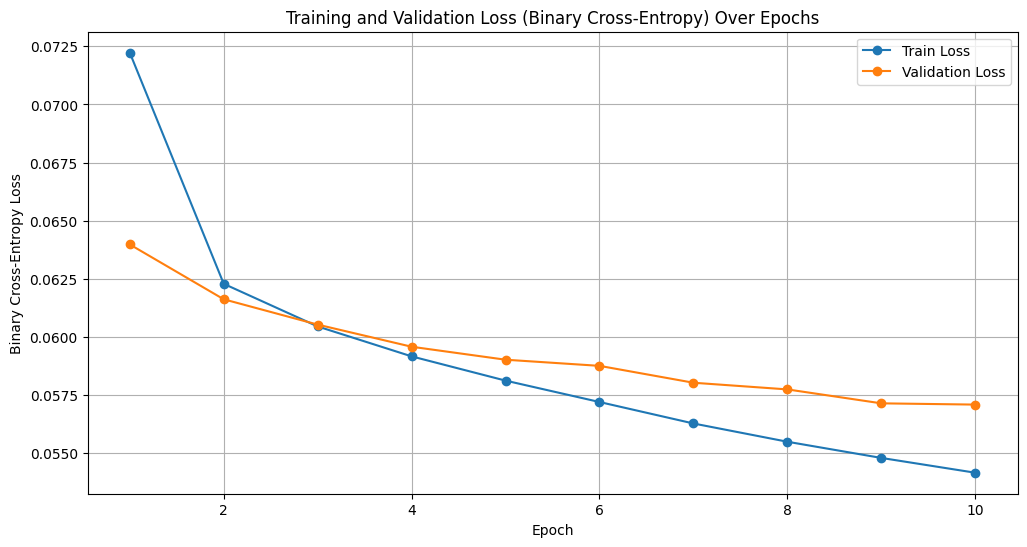

In [30]:
# Plot the training and validation losses over the epochs
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs+1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, num_epochs+1), validation_losses, marker='o', label='Validation Loss')
plt.title('Training and Validation Loss (Binary Cross-Entropy) Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.grid(True)
plt.legend()
plt.show()

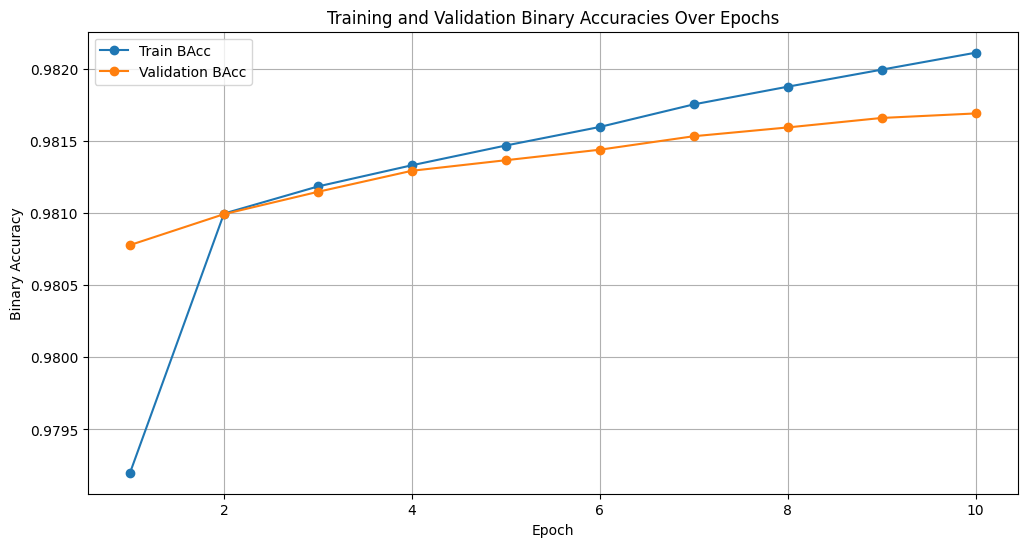

In [31]:
# Plot the training and validation accuracies over the epochs
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs+1), train_accuracies, marker='o', label='Train BAcc')
plt.plot(range(1, num_epochs+1), validation_accuracies, marker='o', label='Validation BAcc')
plt.title('Training and Validation Binary Accuracies Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Binary Accuracy')
plt.grid(True)
plt.legend()
plt.show()

Load the last model, or whichever we wish for

In [32]:
epoch_num_to_load = -1
model = torch.load(f"/kaggle/working/model_{train_losses[epoch_num_to_load]:.4f}_{train_accuracies[epoch_num_to_load]:.4f}_{validation_losses[epoch_num_to_load]:.4f}_{validation_accuracies[epoch_num_to_load]:.4f}.pt")

# Submission

For submission we will use the protein embeddings for the test data

In [33]:
curr_embed_test = embeddings["test"][embed_type]
test_embeddings = np.load(curr_embed_test["embeds_path"])

# Convert test_embeddings to dataframe
column_num = test_embeddings.shape[1]
test_df = pd.DataFrame(test_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(test_df.shape)

(141864, 1280)


The `test_df` is composed of 1024/1280 columns and 141865 entries. We can see all 1024/1280 dimensions (results will be truncated since column length is too long) of our dataset by printing out the first 5 entries using the following code:

In [34]:
test_df.head()

Column_1  Column_2  Column_3  Column_4  Column_5  Column_6  Column_7  \
0 -0.092291 -0.066284 -0.012262  0.044118 -0.096111 -0.028308 -0.074759   
1  0.011624 -0.030318 -0.005802  0.029026  0.028326 -0.034560  0.003770   
2  0.097390 -0.081701 -0.020618  0.094250 -0.139586 -0.134021  0.119044   
3  0.072164 -0.020756  0.053845 -0.029447 -0.061754 -0.086873  0.037167   
4  0.044914 -0.027644  0.014318 -0.003829 -0.024275 -0.121150  0.061480   

   Column_8  Column_9  Column_10  ...  Column_1271  Column_1272  Column_1273  \
0  0.100977  0.024241   0.083448  ...     0.003669    -0.076738    -0.023574   
1 -0.081593 -0.050148  -0.007592  ...     0.082000     0.007247    -0.062506   
2 -0.015649 -0.097181   0.051511  ...     0.114983    -0.049459    -0.049249   
3  0.010195  0.046053  -0.017594  ...     0.099852     0.025191    -0.030697   
4 -0.137826  0.049714   0.034342  ...    -0.016053    -0.049272    -0.034264   

   Column_1274  Column_1275  Column_1276  Column_1277  Column_1278  \
0     0.013527    -0.104102    -0.047541     0.043210    -0.160660   
1     0.095455    -0.063068    -0.010131     0.042478    -0.153411   
2     0.108989     0.042505    -0.056931    -0.079801    -0.117733   
3     0.026832     0.025899    -0.005590     0.080776    -0.047982   
4    -0.050692     0.048096    -0.071397     0.146060    -0.092589   

   Column_1279  Column_1280  
0     0.015920     0.001738  
1     0.006632     0.001425  
2     0.037977     0.056055  
3     0.036235     0.084320  
4    -0.011011     0.014084  

[5 rows x 1280 columns]

We will now use the model to make predictions on the test embeddings. 

In [35]:
test_data_tensor = torch.tensor(test_df.values, dtype=torch.float32)
model.eval()
with torch.no_grad():
    predictions = model(test_data_tensor)

Clear everything so we have more space on RAM for creating the submission file

In [36]:
del model
gc.collect()

7644

From the predictions we will create the submission data frame.

In [37]:
test_protein_ids = np.load(curr_embed_test["ids_path"])
df_submission = pd.DataFrame(predictions, index=test_protein_ids, columns=labels).stack()
df_submission = pd.DataFrame({'Protein Id': df_submission.index.get_level_values(0),
                              'GO Term Id': df_submission.index.get_level_values(1),
                              'Prediction': df_submission.values
                             })
df_submission.to_csv("submission.tsv",header=False, index=False, sep="\t")

In [38]:
df_submission

Protein Id  GO Term Id    Prediction
0             Q9ZSA8  GO:0005575  1.678913e-01
1             Q9ZSA8  GO:0008150  8.916643e-01
2             Q9ZSA8  GO:0110165  1.702263e-01
3             Q9ZSA8  GO:0003674  6.569982e-01
4             Q9ZSA8  GO:0005622  1.400832e-01
...              ...         ...           ...
212795995     P0AG74  GO:0051783  1.633578e-05
212795996     P0AG74  GO:0031674  1.130978e-06
212795997     P0AG74  GO:0001818  9.764014e-05
212795998     P0AG74  GO:0006874  1.781121e-07
212795999     P0AG74  GO:0016887  2.416750e-03

[212796000 rows x 3 columns]